**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio1210\\cplex\\python\\3.7\\x64_win64\\cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m20-improved-4.csv'
path_dump_improved = '../output/m22-improved.csv' # output solution

num_cpu_cores = 12
#time_limit = -1 # unlimited
time_limit = 1*24*60*60  # in s

occupancy_diff = 200  # +- the occupancy of input solution for each day
occupancy_diff_low = 200  # +- the occupancy of input solution for each day
max_family_rank = 5  # maximum number of rank of the preference days for each family
use_hint = False      # use current input as hint
occupancy_count_as_variables = False  # use occupancy_counts as variable (seem faster)
redundant_occupancy_constraints = True  # use redundant constraints
min_choice_0_families = 0   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_pref_cost_lower = 0
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 0
target_accounting_cost_lower = 6020
max_accounting_cost_per_day = 500

In [4]:
N_families - 62868 / 50

3742.6400000000003

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
#print(list(days))

In [7]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [8]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     69652.011085299
Preference cost: 64015
Accounting cost: 5637.011085299005


In [9]:
print(occupancy, occupancy.shape)

[125 300 288 300 300 285 263 249 249 269 296 300 297 273 262 254 273 296
 294 275 247 223 228 256 283 300 292 273 258 251 246 275 279 256 224 196
 167 192 227 251 236 206 176 160 125 294 276 251 219 188 156 125 282 260
 231 195 160 127 125 263 238 205 163 125 125 125 246 219 183 139 125 125
 125 225 206 173 128 125 125 125 229 211 181 138 126 125 125 253 231 199
 157 125 125 125 225 204 171 126 125 125 125 125] (102,)


In [10]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

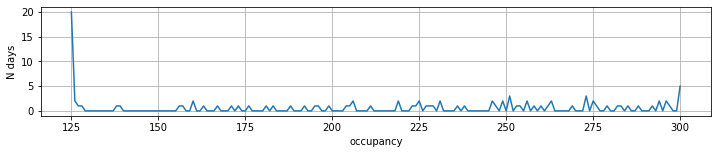

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [12]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

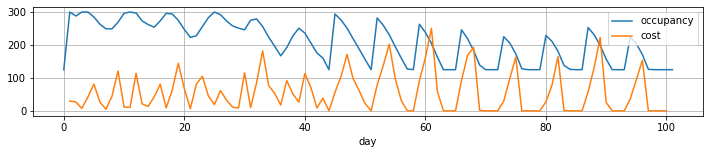

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [14]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

250.48410034179688 1       29.788443
2       26.920185
3        7.577722
4       41.944504
5       81.210869
          ...    
96     153.777359
97       0.030912
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


### Family preferred days

In [15]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [16]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [17]:
day_rank_count

array([[   0, 1576,  202, ...,   56,   57,   43],
       [   0, 1478,  131, ...,   53,   64,   41],
       [   0, 1337,  168, ...,   48,   39,   62],
       ...,
       [   0, 1053,  201, ...,   70,   34,   71],
       [   0,  830,  217, ...,   38,   41,   73],
       [   0,  845,  158, ...,   54,   69,   56]])

In [18]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [19]:
day_rank_acc_count

array([[    0,  1576,   202, ...,    56,    57,    43],
       [    0,  2956,   262, ...,   106,   128,    82],
       [    0,  4152,   467, ...,   149,   142,   165],
       ...,
       [    0,  9370,  1430, ...,   491,   398,   496],
       [    0,  9977,  1663, ...,   497,   446,   571],
       [    0, 10837,  1762, ...,   567,   543,   610]])

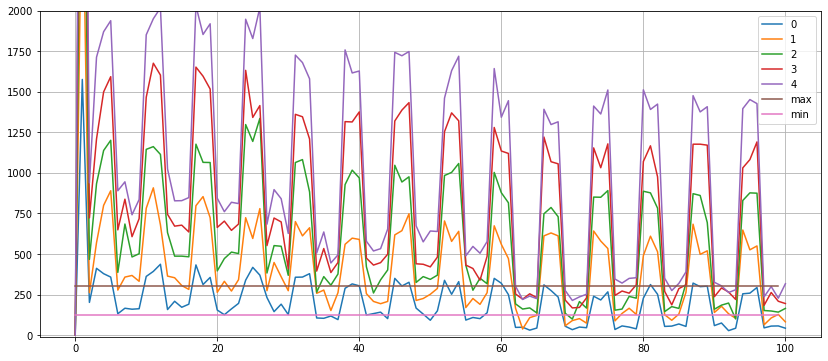

In [20]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.ylim(-10, 2000)
plt.grid(); plt.legend(); plt.show()

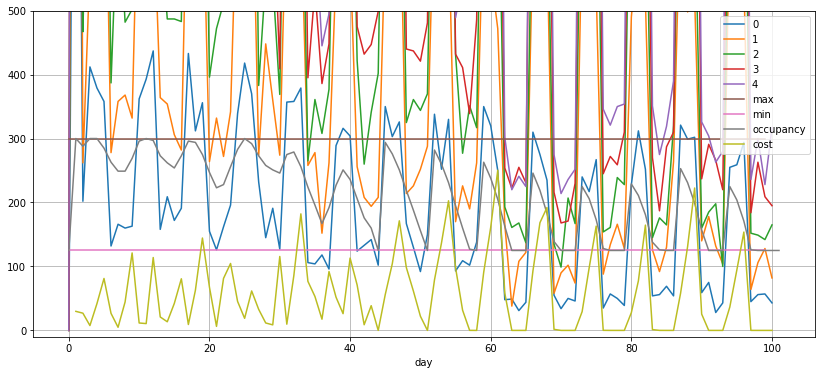

In [21]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

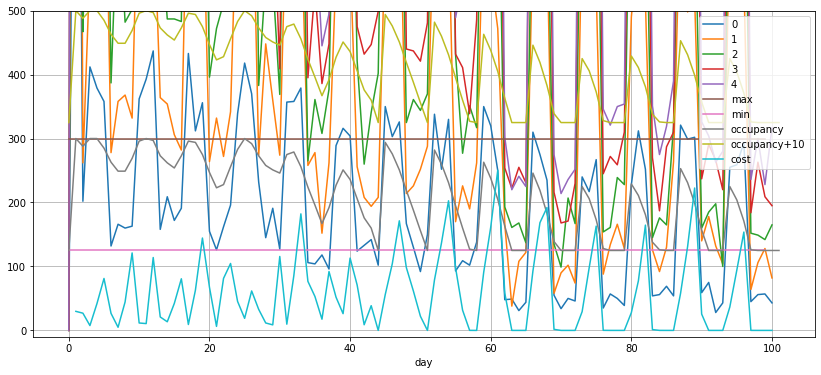

In [22]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+occupancy_diff_low, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

## Setup

In [23]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    if day == 1:
        search_occupancy[day] = range(N_max_people - 6, N_max_people + 1)
    elif day == N_days:
        search_occupancy[day] = range(N_min_people, N_min_people + 7)
    elif occupancy[day] == N_min_people:
        search_occupancy[day] = range(N_min_people, min(occupancy[day] + occupancy_diff_low, N_max_people) + 1)
    else:
        search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                      min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [24]:
for i, x in search_occupancy.items():
    print(i, x)

1 range(294, 301)
2 range(125, 301)
3 range(125, 301)
4 range(125, 301)
5 range(125, 301)
6 range(125, 301)
7 range(125, 301)
8 range(125, 301)
9 range(125, 301)
10 range(125, 301)
11 range(125, 301)
12 range(125, 301)
13 range(125, 301)
14 range(125, 301)
15 range(125, 301)
16 range(125, 301)
17 range(125, 301)
18 range(125, 301)
19 range(125, 301)
20 range(125, 301)
21 range(125, 301)
22 range(125, 301)
23 range(125, 301)
24 range(125, 301)
25 range(125, 301)
26 range(125, 301)
27 range(125, 301)
28 range(125, 301)
29 range(125, 301)
30 range(125, 301)
31 range(125, 301)
32 range(125, 301)
33 range(125, 301)
34 range(125, 301)
35 range(125, 301)
36 range(125, 301)
37 range(125, 301)
38 range(125, 301)
39 range(125, 301)
40 range(125, 301)
41 range(125, 301)
42 range(125, 301)
43 range(125, 301)
44 range(125, 301)
45 range(125, 301)
46 range(125, 301)
47 range(125, 301)
48 range(125, 301)
49 range(125, 301)
50 range(125, 301)
51 range(125, 301)
52 range(125, 301)
53 range(125, 301)
54

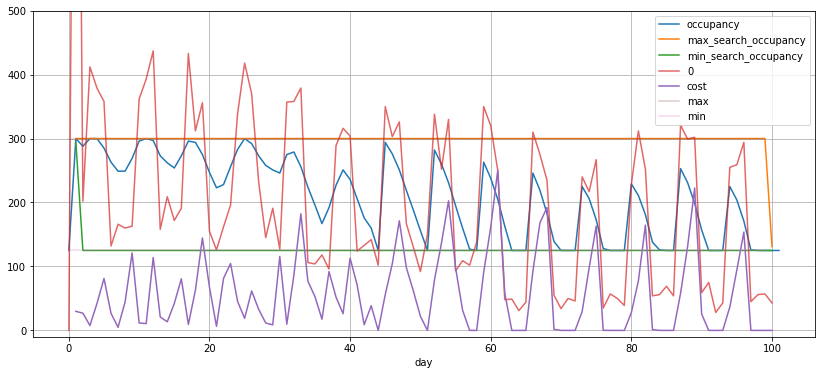

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(occupancy, label='occupancy')
plt.plot(pd.Series({d: max(v) for d, v in search_occupancy.items()}), label='max_search_occupancy')
plt.plot(pd.Series({d: min(v) for d, v in search_occupancy.items()}), label='min_search_occupancy')
for i in range(1):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i), alpha=0.7)
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.plot([N_max_people]*N_days, label='max', alpha=0.3)
plt.plot([N_min_people]*N_days, label='min', alpha=0.3)
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

In [26]:
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality <= max_accounting_cost_per_day

In [27]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

15130

(125, 300)

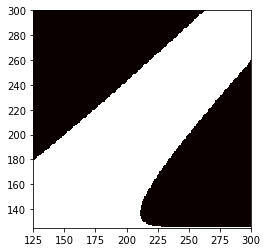

In [28]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [29]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 5


In [30]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, 136, 236],
       [  0,  50,  86, 136, 236],
       [  0,  50,  77, 127, 227],
       ...,
       [  0,  50, 104, 154, 254],
       [  0,  50,  95, 145, 245],
       [  0,  50,  86, 136, 236]], dtype=int64)

## DOCplex model

In [31]:
from docplex.mp.model import Model

In [32]:
solver = Model('')

In [33]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 12
Num treads: threads:int(12)
Set time limit: None


In [34]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [35]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [36]:
len(assignment_matrix)

25000

In [37]:
possible_family_sizes = np.unique(n_people)

In [38]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [39]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                if viable_nd_ndp1[o, o_next]:
                    occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            if viable_nd_ndp1[o, o]:
                occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [40]:
search_occupancy[N_days]

range(125, 132)

In [41]:
len(occupancy_matrix)

1468299

## Constraints

### constraint 1: each family only take one day (choice)

In [42]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [43]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [44]:
# constraint 2: each day can only have 125-300 people

In [45]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

5

In [46]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [47]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [48]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [49]:
if not occupancy_count_as_variables:
    for day in days:
        solver.add_range(min(search_occupancy[day]), 
                         occupancy_counts[day], 
                         max(search_occupancy[day]))

### constraint 3: unpreferred day family count conservation for each family size

In [50]:
# constraint 3: unpreferred day family count conservation for each family size

In [51]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [52]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [53]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [54]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]            
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [55]:
# next day occupancy consistency
solver.add_constraints_([
    occupancy_counts[day + 1] == solver.sum([
        occupancy_matrix[day, o, o_next] * o_next 
        for o in search_occupancy[day]
        for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next]            
    ])
    for day in days if day < N_days
])

# redudant constraints
if redundant_occupancy_constraints:
    for day in days:
        if day + 1 < N_days:
            solver.add_constraints_([
                solver.sum([
                    occupancy_matrix[day, o_other, o] 
                    for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]
                ]) == solver.sum([
                    occupancy_matrix[day + 1, o, o_other]
                    for o_other in search_occupancy[day + 2] if viable_nd_ndp1[o, o_other]
                ])
                for o in search_occupancy[day + 1]
            ])
    solver.add_constraints_([
        solver.sum([
            occupancy_matrix[N_days - 1, o_other, o] 
            for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]
        ]) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
        for o in search_occupancy[N_days]
    ])

### Preference cost

In [56]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(1, N_choices)
])

In [57]:
if target_pref_cost > 0:
    if target_pref_cost_error > 0:
        print('Limit preference cost in range')
        solver.add_range(
            target_pref_cost - target_pref_cost_error,
            family_pref_cost,
            target_pref_cost + target_pref_cost_error
        )
    else:
        print('Limit preference cost exactly')
        solver.add_constraint_(family_pref_cost == target_pref_cost)
elif target_pref_cost_lower > 0:
    print('Lower bound preference cost')
    solver.add_constraint_(family_pref_cost >= target_pref_cost_lower)

### Accounting cost

In [58]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next] and o > N_min_people
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
        if viable_nd_ndp1[o, o] and o > N_min_people  
    ])
)

In [59]:
if target_accounting_cost > 0:
    if target_accounting_cost_error > 0:
        print('Range limit accounting cost')
        solver.add_range(
            target_accounting_cost - target_accounting_cost_error,
            accounting_cost,
            target_accounting_cost - target_accounting_cost_error
        )
elif target_accounting_cost_lower > 0:
    print('Lower bound accounting cost')
    solver.add_constraint_(accounting_cost >= target_accounting_cost_lower)

Lower bound accounting cost


In [60]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [61]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [62]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        var_value_map[occupancy_matrix[day, o, o_next]] = float(
                            (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                        )
                    else:
                        assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                        'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
    for o in search_occupancy[N_days]:
        if viable_nd_ndp1[o, o]:
            var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
        else:
            assert not (occupancy[N_days] == o), \
            'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)

## Solve

In [63]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
from docplex.mp.progress import SolutionRecorder

See http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.progress.html#docplex.mp.progress.ProgressClock for progress clock parameters meaning

In [64]:
class MyProgressListener(SolutionRecorder):
    def __init__(self, clock=ProgressClock.Gap, absdiff=None, reldiff=None):
        super(MyProgressListener, self).__init__(clock, absdiff, reldiff)
        self.current_objective = initial_score or 999999
        
    def notify_solution(self, sol):
        if self.current_progress_data.current_objective >= self.current_objective:
            return
        print ('Improved solution')
        super(MyProgressListener, self).notify_solution(sol)
        self.current_objective = self.current_progress_data.current_objective
        assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
        for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
            assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
        solution = pd.DataFrame(data=families, columns = ['family_id'])
        solution['assigned_day'] = assigned_day_new_raw
        #score = cost_function(preds)
        #print('Score: ' + str(score))        
        solution.to_csv(path_dump_improved, index=False)
        
    def get_solutions(self):
        return self._solutions

In [65]:
# print progress
my_progress_listener = MyProgressListener(clock=ProgressClock.Gap)
solver.add_progress_listener(
#     TextProgressListener(clock=ProgressClock.Gap)
    my_progress_listener
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [66]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 1493299 ( 1493299 , 0 )
N of constraints: 22655
Time limit: 86400.0


In [ ]:
%%time
# Solve
sol = solver.solve(log_output=True)

if sol is None:
    sol = my_progress_listener.get_solutions()[-1]

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 12
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               86400
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve has eliminated 1166 rows and 111050 columns...
Presolve has improved bounds 70585 times...
Tried aggregator 1 time.
MIP Presolve eliminated 1166 rows and 111050 columns.
MIP Presolve modified 49768 coefficients.
Reduced MIP has 21489 rows, 1382349 columns, and 8225584 nonzeros.
Reduced MIP has 1382264 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 9.63 sec. (16214.89 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 21489 rows, 1382349 columns, and 8225584 nonzeros.
Reduced MIP has 1382264 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 5.81 sec. (4073.41 ticks)
Probing time = 1.09 sec. (815.87 ticks)
Cli

Elapsed time = 4827.44 sec. (6684673.44 ticks, tree = 10.14 MB, solutions = 0)
     71    53    68676.5105  1063                  68632.3169   181558         
     73    34    68671.1239  1079                  68632.3169   147384         
     75    49    68678.4595  1019                  68632.3169   173208         
     77    40    68677.1368  1123                  68632.3169   150779         
     79    53    68675.5011  1005                  68632.3169   177625         
     80    59    68673.8225  1044                  68632.3169   193958         
     81    54    68676.9054  1087                  68632.3169   182067         
     82    41    68677.5932  1056                  68632.3169   155699         
     83    50    68678.7052  1040                  68632.3169   173730         
     84    52    68671.3681  1086                  68632.3169   185370         
Elapsed time = 4876.45 sec. (6715573.91 ticks, tree = 8.77 MB, solutions = 0)
     85    55    68674.5732  1094          

    230   185    68710.9963   681                  68635.2020   335485         
    231   163    68752.2927   831                  68635.2020   319188         
    234   172    68694.3140   839                  68635.2020   321427         
    235   164    68752.5255   832                  68635.2020   319592         
    237   168    68702.2064   676                  68635.2020   321145         
    241   198    68702.3932   669                  68635.2020   355637         
    243   193    68692.2796   919                  68635.2020   347913         
Elapsed time = 5966.78 sec. (7327918.70 ticks, tree = 60.45 MB, solutions = 0)
    246   207    68729.3421   577                  68635.2020   361497         
    247   192    68817.0174   635                  68635.2020   344182         
    249   165    68700.5382   809                  68640.2675   318690         
    252   180    68768.5706   592                  68640.2675   332185         
    256   194    68754.6994   772        

   1638   633    69260.3299   128                  68640.2675   499264         
   1698   704    69174.9024   180                  68640.2675   520902         
   1770   666    69339.6031   126                  68640.2675   499760         
Elapsed time = 6692.44 sec. (7743915.78 ticks, tree = 351.44 MB, solutions = 0)
   1839   858    69290.7319   110                  68640.2675   527865         
   1889   749    69310.6924   156                  68640.2675   522179         
   1923   703    69393.9295   160                  68640.2675   500258         
   1991   889    68967.7723   154                  68640.2675   558721         
   2061   898    69340.0472   108                  68640.2675   528795         
   2138   845    68960.3164   324                  68640.2675   565568         
   2181   646    69181.3329   142                  68640.2675   513509         
   2228   830    69385.8832   142                  68640.2675   523931         
   2297   929    68995.0021   172       

   9627  4687    69282.8049   119                  68640.2675   720978         
Elapsed time = 7287.63 sec. (8090843.98 ticks, tree = 3164.02 MB, solutions = 0)
Nodefile size = 955.57 MB (311.65 MB after compression)
   9686  7571    72670.6105    88                  68640.2675   770860         
   9687  7924    72026.4488    82                  68640.2675   808500         
   9708  9661    72135.7226    86                  68640.2675   836092         
   9727  9680    72206.1869    74                  68640.2675   836385         
   9748  9701    72262.2702    78                  68640.2675   836705         
   9768  9721    72275.7702    72                  68640.2675   837046         
   9788  9640    72674.6939    88                  68640.2675   835839         
   9829  9762    72352.6035    84                  68640.2675   837677         
   9877  9784    72432.3535    90                  68640.2675   837939         
   9920  9805    72550.2535    96                  68640.2675  

  15212 13482    74887.5263    76                  68640.2675  1007691         
  15278 14007    75744.1492    79                  68640.2675  1054973         
  15344 13520    75064.6335    72                  68640.2675  1008203         
  15414 13401    69173.6481   172                  68640.2675  1023249         
Elapsed time = 7861.53 sec. (8447948.64 ticks, tree = 9383.40 MB, solutions = 0)
Nodefile size = 7261.20 MB (2384.31 MB after compression)
  15491 14054    75943.3159    77                  68640.2675  1055295         
  15542 14237    75497.8597    72                  68640.2675  1062219         
  15606 14089    75794.8159    79                  68640.2675  1055539         
  15699 14285    69059.9935   260                  68640.2675  1066501         
  15770 14292    75754.8478    80                  68640.2675  1062896         
  15824 13775    70730.7210   134                  68640.2675  1038301         
  15882 14390    69276.8003   144                  68640.2675

  21360 19121    70531.5945   100                  68640.2675  1247504         
  21434 19460    74750.1901    72                  68640.2675  1242791         
  21509 19478    74879.0235    70                  68640.2675  1243084         
  21585 20447    70769.9085   124                  68640.2675  1289764         
  21684 19926    71963.3930    78                  68640.2675  1255131         
  21774 19624    69529.6325   141                  68640.2675  1252613         
  21868 19549    74958.7259    68                  68640.2675  1244300         
Elapsed time = 8445.33 sec. (8795153.62 ticks, tree = 13783.34 MB, solutions = 0)
Nodefile size = 11485.21 MB (3781.43 MB after compression)
  21952 20306    82463.1765    71                  68640.2675  1274143         
  22021 20325    82818.8217    60                  68640.2675  1274553         
  22088 20727    69542.0809   151                  68640.2675  1300838         
  22192 21308    75044.9997    76                  68640.26

  26974 25312    80056.5235    72                  68640.2675  1460953         
  27028 25024    72972.1360   110                  68640.2675  1448431         
  27087 25504    68948.1841   311                  68640.2675  1474212         
  27146 25064    73110.5566    92                  68640.2675  1449207         
  27202 25655    69948.0204   122                  68640.2675  1465531         
  27262 25405    80501.5235    70                  68640.2675  1462527         
  27311 25683    70064.9227   122                  68640.2675  1465805         
  27369 25703    70086.5321   124                  68640.2675  1465967         
  27431 25161    73331.2828    90                  68640.2675  1450860         
  27485 25743    70140.3513   120                  68640.2675  1466493         
Elapsed time = 9088.75 sec. (9143509.35 ticks, tree = 18182.22 MB, solutions = 0)
Nodefile size = 15906.47 MB (5249.16 MB after compression)
  27533 25201    73479.9614    88                  68640.26

  32247 30750    74324.6873    76                  68640.2675  1665613         
Elapsed time = 9647.72 sec. (9453411.37 ticks, tree = 21761.14 MB, solutions = 0)
Nodefile size = 19433.62 MB (6427.03 MB after compression)
  32319 30422    87571.8568    62                  68640.2675  1662353         
  32376 30783    74664.7627    94                  68640.2675  1665998         
  32426 30943    infeasible                        68640.2675  1697136         
  32486 30964    78912.0328    78                  68640.2675  1697394         
  32560 30983    78920.3661    80                  68640.2675  1697652         
  32633 31362    87736.0235    66                  68640.2675  1704075         
  32695 31383    87863.8568    56                  68640.2675  1704347         
  32751 31760    75393.3302    82                  68640.2675  1709443         
  32826 31779    75520.9731    78                  68640.2675  1709772         
  32900 30742    69538.2291   116                  68640.26

  37754 36118    infeasible                        68640.2675  1974547         
  37819 36244    79704.6873    78                  68640.2675  1885181         
  37870 36875    79707.0207    76                  68640.2675  1988535         
  37937 36889    79770.5207    86                  68640.2675  1988687         
Elapsed time = 10306.19 sec. (9801413.60 ticks, tree = 26169.02 MB, solutions = 0)
Nodefile size = 24048.45 MB (7993.35 MB after compression)
  38009 36904    80218.3540    74                  68640.2675  1988899         
  38081 36253    71832.8248   109                  68640.2675  1949773         
  38151 36273    71894.5863   101                  68640.2675  1949973         
  38221 36567    96859.7953    58                  68640.2675  1988184         
  38292 36587    97009.1427    50                  68640.2675  1988612         
  38361 36331    72024.5863   103                  68640.2675  1950680         
  38424 37017    80811.2350    58                  68640.2

  41327 39269    68895.1437   232                  68640.2675  2269421         
  41363 39408    69053.9366   166                  68640.2675  2295737         
  41392 39564    84633.9135    64                  68640.2675  2280147         
  41421 39423    69073.5551   154                  68640.2675  2296438         
  41450 39602    85010.1318    67                  68640.2675  2280866         
  41465 39778    85052.1318    78                  68640.2675  2318393         
  41495 39799    85261.0838    66                  68640.2675  2318686         
Elapsed time = 10951.20 sec. (10151829.99 ticks, tree = 28235.53 MB, solutions = 0)
Nodefile size = 26107.27 MB (8705.35 MB after compression)
  41523 39818    85442.1076    68                  68640.2675  2319012         
  41553 39837    85613.1327    78                  68640.2675  2319338         
  41580 39467    69090.9743   156                  68640.2675  2298667         
  41616 39477    69094.5433   183                  68640.

  46060 42204    69140.5849   130                  68640.2675  2512641         
  46129 42221    69146.8380   131                  68640.2675  2513204         
  46196 42845    71935.3308    68                  68640.2675  2532391         
  46272 43648    69037.1260   249                  68640.2675  2569614         
  46351 43639    71255.1617    88                  68640.2675  2553223         
  46444 42894    72171.4975    74                  68640.2675  2533906         
  46532 43680    69083.8780   189                  68640.2675  2573610         
  46628 43696    69091.3229   198                  68640.2675  2574196         
  46704 43712    71427.2569    84                  68640.2675  2554193         
  46787 43731    71430.4458   102                  68640.2675  2554523         
Elapsed time = 11589.03 sec. (10499662.03 ticks, tree = 31062.31 MB, solutions = 0)
Nodefile size = 28784.40 MB (9587.40 MB after compression)
  46870 44026    69504.3699   129                  68640.

## Solution

In [ ]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [ ]:
assigned_day_new_raw

In [ ]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [ ]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [ ]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [ ]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

In [ ]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [ ]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

## Output

In [ ]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [ ]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])